<a href="https://colab.research.google.com/github/Imaspson/PyTorchLearning/blob/main/03_PyTorch_HW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from sklearn.datasets import make_moons

n_samples = 1000

X, y = make_moons(n_samples,
                  noise=0.03,
                  random_state=42)

In [2]:
print(f"First 5 X features:\n{X[:5]}")
print(f"\nFirst 5 y labels:\n{y[:5]}")

First 5 X features:
[[-0.00933187  0.39098105]
 [ 0.95457387 -0.47375583]
 [ 0.9185256  -0.42519648]
 [ 0.41276802 -0.37638459]
 [-0.84532016  0.52879908]]

First 5 y labels:
[1 1 1 1 0]


In [5]:
import pandas as pd
moons = pd.DataFrame({"X1": X[:, 0],
    "X2": X[:, 1],
    "label": y
})
moons.head(10)

,X1,X2,label
0,-0.009332,0.390981,1
1,0.954574,-0.473756,1
2,0.918526,-0.425196,1
3,0.412768,-0.376385,1
4,-0.845320,0.528799,0
5,0.579542,-0.352979,1
6,0.294884,-0.209238,1
7,-0.014488,0.435896,1
8,1.626510,-0.281207,1
9,0.671598,0.786422,0


In [6]:
moons.label.value_counts()

1    500
0    500
Name: label, dtype: int64

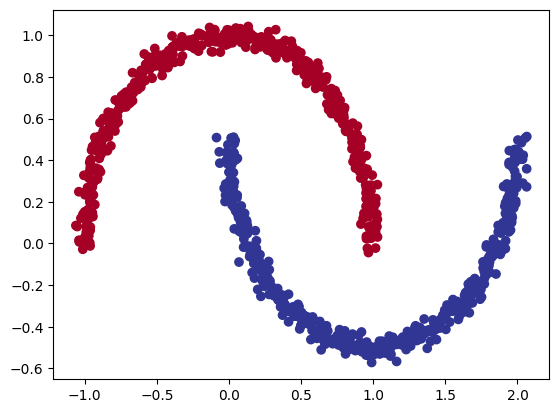

In [7]:
# Visualize
import matplotlib.pyplot as plt
plt.scatter(x=X[:, 0],
            y=X[:, 1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [8]:
X.shape, y.shape

((1000, 2), (1000,))

In [10]:
import torch
X = torch.from_numpy(X).type(torch.float)
y = torch.from_numpy(y).type(torch.float)

X[:5], y[:5]

(tensor([[-0.0093,  0.3910],
         [ 0.9546, -0.4738],
         [ 0.9185, -0.4252],
         [ 0.4128, -0.3764],
         [-0.8453,  0.5288]]),
 tensor([1., 1., 1., 1., 0.]))

In [11]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

len(X_train), len(X_test), len(y_train), len(y_test)

(800, 200, 800, 200)

In [12]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [69]:
class MoonModelV0(nn.Module):
  def __init__(self, input_features, output_features, hidden_units=8):
    super().__init__()
    self.layer_stack = nn.Sequential(
        nn.Linear(in_features=input_features, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=hidden_units),
        nn.ReLU(),
        nn.Linear(in_features=hidden_units, out_features=output_features),
    )

  def forward(self, x):
    return self.layer_stack(x)

In [70]:
model_0 = MoonModelV0(input_features=2,
                      output_features=1,
                      hidden_units=8).to(device)
model_0

MoonModelV0(
  (layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=8, bias=True)
    (3): ReLU()
    (4): Linear(in_features=8, out_features=1, bias=True)
  )
)

In [71]:
# Loss and optimizer
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.SGD(model_0.parameters(), lr=0.1)

In [72]:
model_0(X_train.to(device))[0].shape

torch.Size([1])

In [73]:
# Make prediction logits with model
y_logits = model_0(X_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[-0.0971],
        [-0.2020],
        [-0.1853],
        [-0.1810],
        [-0.3208]], device='cuda:0', grad_fn=<SliceBackward0>)
tensor([[1.],
        [1.],
        [1.],
        [1.],
        [1.]], device='cuda:0', grad_fn=<SliceBackward0>)


In [74]:
torch.sum(y_pred_probs[0])


tensor(1., device='cuda:0', grad_fn=<SumBackward0>)

In [75]:
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [76]:
# Fit the model
torch.manual_seed(42)
epochs = 1000

# Put all data on target device
X_train, y_train = X_train.to(device), y_train.to(device)
X_test, y_test = X_test.to(device), y_test.to(device)

for epoch in range(epochs):
    # 1. Forward pass
    y_logits = model_0(X_train).squeeze()
    y_pred = torch.round(torch.sigmoid(y_logits)) # logits -> prediction probabilities -> prediction labels

    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_train) # BCEWithLogitsLoss calculates loss using logits
    acc = accuracy_fn(y_true=y_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backward
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_0.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_0(X_test).squeeze()
      test_pred = torch.round(torch.sigmoid(test_logits)) # logits -> prediction probabilities -> prediction labels
      # 2. Calcuate loss and accuracy
      test_loss = loss_fn(test_logits, y_test)
      test_acc = accuracy_fn(y_true=y_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 100 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Accuracy: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Accuracy: {test_acc:.2f}%")

Epoch: 0 | Loss: 0.71197, Accuracy: 50.00% | Test Loss: 0.70553, Test Accuracy: 50.00%
Epoch: 100 | Loss: 0.36094, Accuracy: 85.00% | Test Loss: 0.37427, Test Accuracy: 83.50%
Epoch: 200 | Loss: 0.23891, Accuracy: 88.75% | Test Loss: 0.23956, Test Accuracy: 90.50%
Epoch: 300 | Loss: 0.21818, Accuracy: 89.62% | Test Loss: 0.21428, Test Accuracy: 91.00%
Epoch: 400 | Loss: 0.19766, Accuracy: 90.75% | Test Loss: 0.19220, Test Accuracy: 92.00%
Epoch: 500 | Loss: 0.16549, Accuracy: 92.38% | Test Loss: 0.15952, Test Accuracy: 93.00%
Epoch: 600 | Loss: 0.12185, Accuracy: 95.00% | Test Loss: 0.11589, Test Accuracy: 97.00%
Epoch: 700 | Loss: 0.07915, Accuracy: 98.25% | Test Loss: 0.07359, Test Accuracy: 98.50%
Epoch: 800 | Loss: 0.04976, Accuracy: 99.50% | Test Loss: 0.04512, Test Accuracy: 100.00%
Epoch: 900 | Loss: 0.03289, Accuracy: 100.00% | Test Loss: 0.02925, Test Accuracy: 100.00%


In [77]:
model_0.eval()
with torch.inference_mode():
    y_logits = model_0(X_test)

# View the first 10 predictions
y_logits[:10]

tensor([[ 5.5448],
        [-6.0320],
        [ 5.5481],
        [-6.5611],
        [ 6.8397],
        [ 6.0999],
        [-3.6751],
        [-1.7990],
        [ 5.6288],
        [-5.5528]], device='cuda:0')

In [78]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_test, y_pred=y_preds)}%")

Predictions: tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Labels: tensor([1., 0., 1., 0., 1., 1., 0., 0., 1., 0.], device='cuda:0')
Test accuracy: 50.0%


In [79]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


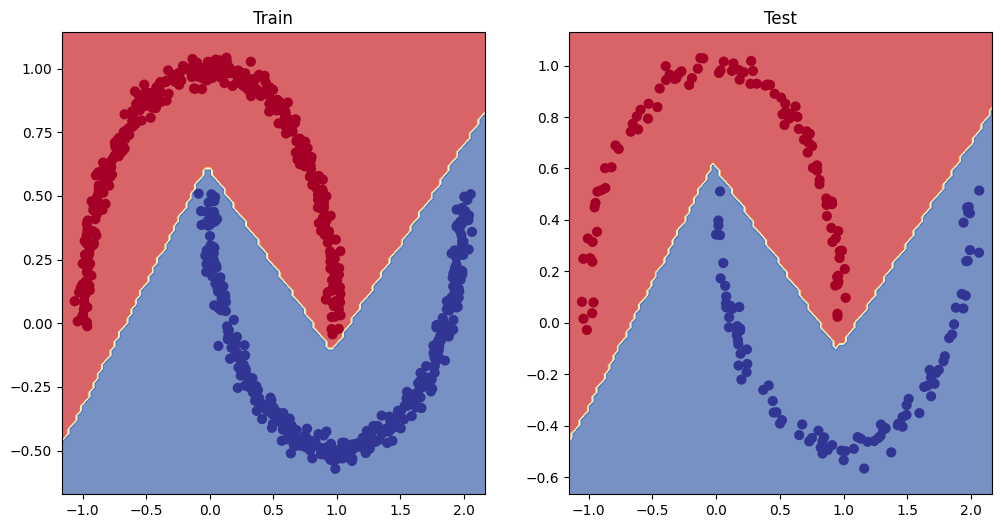

In [80]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_0, X_train, y_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_0, X_test, y_test)